# pandapipes net from .csv tables
### using _plural_ create functions (e.g. `create_junctions`) instead of _singular_ ones ( e.g. `create_junction`)

It has been demonstrated in previous tutorials how a pandapipes net can be created step-by-step by creating each component individually with its respective `create...` function.
In many cases however, pandapipes will be integrated into a tool chain. For larger studies, grid data will likely be downloaded from somewhere, exported from other tools or might be received from another party. One established format for these exchanges is the [.csv-file format](https://en.wikipedia.org/wiki/Comma-separated_values).

This tutorial guides through the creation of a pandapipes net while taking example .csv-files as input.
To make the process more convenient and efficient, _plural_ create functions (e.g. create_junctions) are used.

The .csv files specifying the network are loaded from the "files/example_gas_net_csvs" folder which is located in the same folder as this notebook. They determine the [components](https://pandapipes.readthedocs.io/en/latest/components.html) of the example network used to illustrate this tutorial(see picture below): the junctions (i.e. nodes), the pipes, the external grids and the sinks.

The example network covers an imaginary development area and is designed as shown in the picture:

<img src="pics/gas_example_Longniddry.jpg" width="30%">

#### Import the necessary packages

In [1]:
import pandas as pd
import os
import pandapipes as ppi
from pandapipes.plotting import simple_plot

#### Create an empty pandapipes network

In [2]:
fluid = 'hgas'  # other possible fluids: water, lgas, hydrogen
net = ppi.create_empty_network('gas test network', fluid=fluid) # create empty network

#### Extract the data from the .csv files as pandas DataFrames

The data are extracted as DataFrames using the pandas function `read_csv`. Let's start with the junctions' data.

In [3]:
pre_path = r".\files\example_gas_net_csvs"
junctions_df = pd.read_csv(os.path.join(pre_path,'example_net-junctions.csv'))

Let's take a look at what is in the `junctions_df` DataFrame. The `head()` (from the pandas package) method displays the first 5 rows of the DataFrame, avoiding a crammed output.

In [4]:
junctions_df.head()

,Name,lat,lon,height
0,b0,6270716.410,2760327.163,0.0
1,b1,6270591.372,2759948.189,0.3
2,b2,6270456.361,2760038.450,0.6
3,b3,6270313.571,2760136.418,0.9
4,b4,6270214.431,2760177.492,1.2


The data of the other types of elements is also extracted

In [19]:
pipes_df = pd.read_csv(os.path.join(pre_path, 'example_net-pipes.csv'))
sinks_df = pd.read_csv(os.path.join(pre_path, 'example_net-sinks.csv'))
ext_grids_df = pd.read_csv(os.path.join(pre_path, 'example_net-ext_grid.csv'))
valves_df = pd.read_csv(os.path.join(pre_path, 'example_net-valves.csv'))

pipes_df.head()

,junction,pressure
Name,,
ext_grid1,0,1
ext_grid2,14,1


#### Create the network junctions and pipes based on the DataFrames
After having created an empty network, the next steps is always to create junctions. This is because all other elements are attached to junctions and cannot be created if their junctions do not yet exist.

We can now create all junctions based on the junctions-DataFrame at once, without any for-loop. Since no temperature is given, 10°C is assumed. For the plural-create-function, a single value, list or pandas-Series can be passed as input arguments.

In [7]:
amb_temp = 283.15
geodata = junctions_df[['lon', 'lat']].values
junctions = ppi.create_junctions(net, nr_junctions=len(junctions_df), pn_bar=1, tfluid_k=amb_temp,
                         height_m=junctions_df['height'], geodata=geodata)

The .csv data do not specify any diameter for the pipes. Therefore, a uniform diameter of 0.05 m is assumed for all pipes. Passing a single value as an argument for the diameter assigns this diameter to all pipes. It is alternatively possible to pass an iterable to assign different diameters to different pipes - the iterable would need to have exactly the same length as the other passed iterables.
This is valid for all other relevant parameters for junctions, pipes, sinks, sources...

In [8]:
pipes = ppi.create_pipes_from_parameters(net, pipes_df['from_junction'], pipes_df['to_junction'],
                                     length_km=pipes_df['length_km'], diameter_m=0.05, k_mm=0.2)

Note: There are two [functions to create pipes](https://pandapipes.readthedocs.io/en/latest/components/pipe/pipe_component.html) in pandapipes: `create_pipes_from_parameters` and `create_pipes` (and there are their equivalent _singular_ versions). The former creates pipes while passing the diameters as arguments (the user specifies the diameters while creating the pipes), while the latter creates pipes based on predefined [standard types](https://pandapipes.readthedocs.io/en/latest/standard_types/std_types_in_pandapipes.html).

Let's take a look at the pipes pandapipes table. The `head()` method can also be employed here. This table displays all the input parameters that specifies a pipe. Some are filled with default values since no specific data has been passed to the create function.

In [9]:
net.pipe.head()

,name,from_junction,to_junction,std_type,length_km,diameter_m,k_mm,loss_coefficient,alpha_w_per_m2k,text_k,qext_w,sections,in_service,type
0,None,0,1,None,0.20,0.05,0.2,0.0,0.0,293.0,0.0,1,True,pipe
1,None,1,2,None,0.05,0.05,0.2,0.0,0.0,293.0,0.0,1,True,pipe
2,None,2,3,None,0.05,0.05,0.2,0.0,0.0,293.0,0.0,1,True,pipe
3,None,3,4,None,0.05,0.05,0.2,0.0,0.0,293.0,0.0,1,True,pipe
4,None,2,5,None,0.05,0.05,0.2,0.0,0.0,293.0,0.0,1,True,pipe


The input parameters can however be extended. Let's consider a slightly different .csv file for the pipes (namely _example_net-pipes_companies.CSV_) where the company owning each pipe is specified. This is not a parameter built in `create_pipes_from_parameters` function. This information can however be passed as keyword argument to the create function as follows:

In [10]:
ppi.drop_pipes(net, net.pipe.index) # initially drop all the previously created pipes out of the network

pipes_df = pd.read_csv(os.path.join(pre_path,'example_net-pipes_companies.csv')) # path to the csv file containing the pipes' and additionally the company owning/operating) them

ppi.create_pipes_from_parameters(net, pipes_df['from_junction'], pipes_df['to_junction'],
                                 length_km=pipes_df['length_km'], diameter_m=0.05, k_mm=0.2,
                                 company = pipes_df['company']) # "company" is declared as a new keyword argument
net.pipe.head()

hp.pandapipes.toolbox - INFO: dropped 29 pipes


,name,from_junction,to_junction,std_type,length_km,diameter_m,k_mm,loss_coefficient,alpha_w_per_m2k,text_k,qext_w,sections,in_service,type,company
0,None,0,1,None,0.20,0.05,0.2,0.0,0.0,293.0,0.0,1,True,pipe,company B
1,None,1,2,None,0.05,0.05,0.2,0.0,0.0,293.0,0.0,1,True,pipe,company A
2,None,2,3,None,0.05,0.05,0.2,0.0,0.0,293.0,0.0,1,True,pipe,company B
3,None,3,4,None,0.05,0.05,0.2,0.0,0.0,293.0,0.0,1,True,pipe,company C
4,None,2,5,None,0.05,0.05,0.2,0.0,0.0,293.0,0.0,1,True,pipe,company B


The elements creation is done in the next code cell for the sinks, external grids and valves.

NB: The create functions return the indices of the elements they create. To avoid displaying this output below the cells, the output of these function is assigned to the variables `junctions`, `pipes`, `sinks`, `ext_grids`, and `valves`. These variables have therefore no functional purpose in the present tutorial, only a cosmetic one.

In [11]:
sinks = ppi.create_sinks(net, sinks_df['junction'], mdot_kg_per_s=sinks_df['m_dot'])
ext_grids = ppi.create_ext_grids(net, junctions=ext_grids_df['junction'], p_bar=ext_grids_df['pressure'], t_k=amb_temp)
valves = ppi.create_valves(net, valves_df['from_junction'], valves_df['to_junction'], diameter_m=valves_df['diameter'])

Now, all the data from the csv-files has been converted into pandapipes-components.
It should be checked whether the network is actually feasible, i.e. a pipeflow can be properly calculated.

#### Run a pipeflow

The pipeflow function is responsible for computing the pressures at the nodes and flow rates through the pipes of the network.

In [12]:
ppi.pipeflow(net)

#### Display the results of the pipeflow calculation

Running the pipeflow while among others create _res_ (for results) tables for every type of element. The results for the junctions  and the pipes are displayed as done in the next two cells.

In [13]:
net.res_junction

,p_bar,t_k
0,1.000000,283.15
1,0.999943,283.15
2,0.999926,283.15
3,0.999916,283.15
4,0.999913,283.15
5,0.999908,283.15
6,0.999899,283.15
7,0.999939,283.15
8,0.999909,283.15
9,0.999890,283.15


In [14]:
net.res_pipe.head()

,v_from_m_per_s,v_to_m_per_s,v_mean_m_per_s,p_from_bar,p_to_bar,t_from_k,t_to_k,mdot_from_kg_per_s,mdot_to_kg_per_s,vdot_norm_m3_per_s,reynolds,lambda,normfactor_from,normfactor_to
0,0.139734,0.139741,0.139738,1.000000,0.999943,283.15,283.15,0.000373,-0.000373,0.000528,887.107091,0.100526,0.519405,0.519430
1,0.139741,0.139745,0.139743,0.999943,0.999926,283.15,283.15,0.000373,-0.000373,0.000528,887.107091,0.100526,0.519430,0.519443
2,0.064891,0.064892,0.064892,0.999926,0.999916,283.15,283.15,0.000173,-0.000173,0.000245,411.547674,0.183892,0.519443,0.519455
3,-0.009963,-0.009963,-0.009963,0.999916,0.999913,283.15,283.15,-0.000027,0.000027,-0.000038,64.011744,1.028198,0.519455,0.519465
4,0.074854,0.074858,0.074856,0.999926,0.999908,283.15,283.15,0.000200,-0.000200,0.000283,475.559418,0.162959,0.519443,0.519476


By using pandas `concat` function, it is possible to display input parameters and results in the same DataFrame:

In [20]:
pd.concat([net.pipe[["from_junction", "to_junction"]], net.res_pipe.v_mean_m_per_s], axis=1)

,from_junction,to_junction,v_mean_m_per_s
0,0,1,0.139738
1,1,2,0.139743
2,2,3,0.064892
3,3,4,-0.009963
4,2,5,0.074856
5,3,6,0.074858
6,0,7,0.287235
7,7,8,0.212401
8,8,9,0.137546
9,7,10,0.074862


#### Plot the network
The parameters `plot_sinks` enable the plotting of sinks. The plotted size of the valves and junctions is tuned via the parameters `valve_size` and `junction_size`.

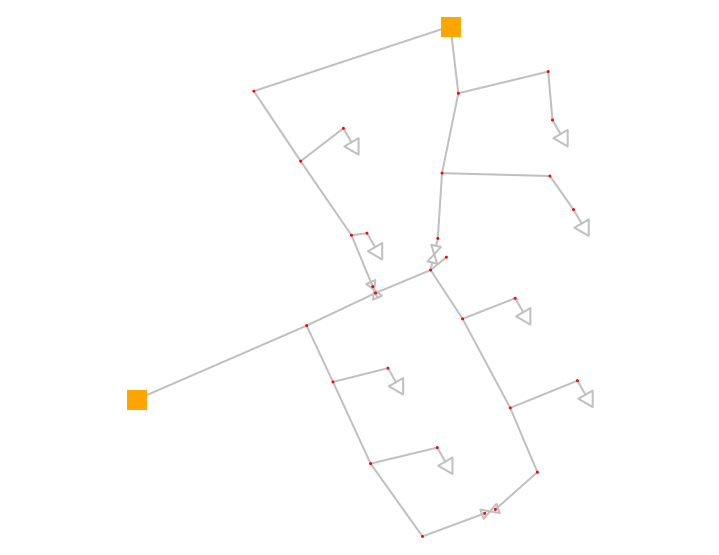

<AxesSubplot:>

In [16]:
simple_plot(net, plot_sinks=True, valve_size=0.6, junction_size=0.2)

#### Save and load the network

It is possible to save the network as .json file and to load it later. Loading a network from json is much faster than creating the whole network from csv-files again.

The network is saved as the file "from_csv_example_gas.json".

In [17]:
ppi.to_json(net, "from_csv_example_gas.json")

In [ ]:
loaded_net = ppi.from_json("from_csv_example_gas.json")